In this tutorial, we will study how to learn text (word) embeddings and do a few experiments to see if these embeddings can capture the meaning of words:
* Continous bag of words (CBOW)
* Skig-gram


In [7]:
#you may need to consider the following
!pip3 install nltk
!pip3 install tensorboardX
#nltk.download('punkt')
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from tensorboardX import SummaryWriter
import numpy as np

### Tokenizing text

In [8]:
s='naive descriptions of Continous bag of words model here: CBOW is learning to predict the word by the context. Or maximize the probability of the target word by looking at the context. And this happens to be a problem for rare words. For example, given the context yest'
output = word_tokenize(s)
print(output)

['naive', 'descriptions', 'of', 'Continous', 'bag', 'of', 'words', 'model', 'here', ':', 'CBOW', 'is', 'learning', 'to', 'predict', 'the', 'word', 'by', 'the', 'context', '.', 'Or', 'maximize', 'the', 'probability', 'of', 'the', 'target', 'word', 'by', 'looking', 'at', 'the', 'context', '.', 'And', 'this', 'happens', 'to', 'be', 'a', 'problem', 'for', 'rare', 'words', '.', 'For', 'example', ',', 'given', 'the', 'context', 'yest']


### Continous Bag Of Words
Some naive descriptions of Continous bag of words model here: CBOW is learning to predict the word by the context. Or maximize the probability of the target word by looking at the context. And this happens to be a problem for rare words. For example, given the context yesterday was a really [...] day CBOW model will tell you that most probably the word is beautiful or nice. Words like delightful will get much less attention of the model, because it is designed to predict the most probable word. This word will be smoothed over a lot of examples with more frequent words.

We first define a dataset class which can act as a placehoder for the text data.

In [9]:
class CBOWDataSet(Dataset):
    """
    We are just training word embeddings, what we need is just text,
    And thus we do not perform train, val, test splitting and sort of
    things. You can change the data file to whatever you want as long
    as it's plain text, and it's not that big.
    It's toy implementation, train on rather small dataset,
    so we don't restrict vocabulary size.
    """
    def __init__(self, data_file_path, window_size=2):
        """
        :param data_file_path: path for the plain text file
        :param ngram:  language model n-grams
        """
        with open(data_file_path,'r',encoding='utf-8') as f:
            s = f.read().lower()
        words_tokenized = word_tokenize(s)

        self.context_target =  [([words_tokenized[i-(j+1)] for j in range(window_size)] +\
                                 [words_tokenized[i+(j+1)] for j in range(window_size)],
                                words_tokenized[i])
                                for i in range(window_size, len(words_tokenized)-window_size)]

        self.vocab = Counter(words_tokenized)
        self.word_to_idx = {word_tuple[0]: idx for idx, word_tuple in enumerate(self.vocab.most_common())}
        self.idx_to_word = list(self.word_to_idx.keys())
        self.vocab_size = len(self.vocab)
        self.window_size = window_size

    def __getitem__(self, idx):
        context = torch.tensor([self.word_to_idx[w] for w in self.context_target[idx][0]])
        target = torch.tensor([self.word_to_idx[self.context_target[idx][1]]])
        return context, target

    def __len__(self):
        return len(self.context_target)

Define the Continous bag of words model now: 

In [10]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, window_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.window_size = window_size

    def forward(self, inputs):

        embeds = torch.sum(self.embeddings(inputs), dim=1) # [200, 4, 50] => [200, 50]
        # embeds = self.embeddings(inputs).view((batch_size, -1))
        out = self.linear(embeds) # nonlinear + projection
        log_probs = F.log_softmax(out, dim=1) # softmax compute log probability

        return log_probs


In [11]:
from google.colab import drive
drive.mount('/content/drive')
#replace the following path according to your Google Drive path
#%cd/gdrive/My Drive/Monash-FIT-S1-2022/Basic-CYK-Parser
folder_path = "/content/drive/MyDrive/Monash-FIT-S1-2023/week9"

Mounted at /content/drive


We set some key hyper-parameters here:

In [13]:
#Key hyperparameters
WINDOWS_SIZE = 2
EMBEDDING_DIM = 50
BATCH_SIZE = 500
NUM_EPOCH = 10

# I think torchtext is really hard to use
# It's a toy example, so you can use any plain text dataset
data_file_path = folder_path + '/corpus/trump_news.txt'

Before training, we do some initialization.

In [14]:
data_CBOW = CBOWDataSet(data_file_path=data_file_path)
model_CBOW = CBOW(len(data_CBOW.vocab), EMBEDDING_DIM, WINDOWS_SIZE)
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model_CBOW.parameters(), lr=0.01)
loss_function = nn.NLLLoss()
losses = []
cuda_available = torch.cuda.is_available()
data_loader = DataLoader(data_CBOW, batch_size=BATCH_SIZE)

# Writer
writer = SummaryWriter('./logs/CBOW')

In [15]:
print(len(data_CBOW.vocab))
print(data_CBOW.idx_to_word)

16370
['the', ',', '.', 'to', 'of', 'a', 'and', 'in', '“', '”', '’', 'trump', 'that', 'on', 's', 'said', 'he', 'for', 'is', 'with', 'his', 'as', 'it', 'was', 'us', 'has', 'by', 'president', 'from', 'have', 'not', 'at', 'be', 'an', 'but', 'are', 'who', 'would', 'will', 'we', 'i', '—', 'this', 'had', 'house', 'which', 'they', 'been', 'its', 'after', 'their', 'also', "''", 'or', 'were', '``', '(', ')', 'white', 'about', 'if', 'new', 'over', 'states', 'no', 'two', 'washington', 'united', 'our', 'into', 'more', 'out', 'told', 'china', 'all', 'against', 'north', 'up', 'what', 'him', 'state', 'there', ':', 'last', 'could', 'can', 'one', 'people', 'when', 'trade', 'biden', 'other', 't', 'you', 'she', 'country', 'iran', "'s", 'first', 'some', 'year', 'between', 'deal', 'while', 'ukraine', 'foreign', 'democrats', '‘', 'meeting', 'do', 'may', 'any', 'leader', 'impeachment', 'security', 'so', 'democratic', 'than', 'very', 'before', 'administration', 'back', 'military', 'time', 'her', 'donald', 'wo

The exact training process happens now, note there is now a PyTorchLighting which can save some work, can explore by yourself.

In [16]:
for epoch in range(NUM_EPOCH):
    total_loss = 0
    for context, target in tqdm(data_loader):
        # context: torch.Size([10, 4])
        # target:  torch.Size([10, 1])
        if context.size()[0] != BATCH_SIZE:
            continue
        # deal with last several batches

        if cuda_available:
            context = context.cuda()
            target = target.squeeze(1).cuda()
            model_CBOW = model_CBOW.cuda()
        else:
            target = target.squeeze(1)

        model_CBOW.zero_grad()
        log_probs = model_CBOW(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss)
    writer.add_scalar('Train/Loss', total_loss, epoch)

    # TODO add visualization of embedding
    # writer.add_embedding(model.embeddings.weight, metadata=data.word_to_idx.keys(), global_step=epoch)
    # It should work, but unfortunately not. see this issue, it seems like a tensorboard 1.11.0's
    # https://github.com/tensorflow/tensorboard/issues/1480

    print('total_loss:',total_loss)

writer.close()
torch.save(model_CBOW.state_dict(), "CBOW.pt")

100%|██████████| 490/490 [01:14<00:00,  6.60it/s]


total_loss: 3339.9383125305176


100%|██████████| 490/490 [01:13<00:00,  6.64it/s]


total_loss: 2658.180614709854


100%|██████████| 490/490 [01:14<00:00,  6.62it/s]


total_loss: 2337.548223257065


100%|██████████| 490/490 [01:14<00:00,  6.58it/s]


total_loss: 2101.232918739319


 44%|████▍     | 218/490 [00:31<00:38,  7.01it/s]


KeyboardInterrupt: ignored

### SkipGram

In [17]:
class SkipGramDataSet(Dataset):
    """
    We are just training word embeddings, what we need is just text,
    And thus we do not perform train, val, test splitting and sort of
    things. You can change the data file to whatever you want as long
    as it's plain text, and it's not that big.
    It's toy implementation, train on rather small dataset,
    so we don't restrict vocabulary size.
    """
    def __init__(self, data_file_path, window_size=2):
        """
        :param data_file_path: path for the plain text file
        :param ngram:  language model n-grams
        """
        with open(data_file_path,'r',encoding='utf-8') as f:
            s = f.read().lower()
        words_tokenized = word_tokenize(s)
        # pairs
        self.word_pair = [(words_tokenized[i], words_tokenized[i+j]) for j in range(-window_size, window_size + 1) if j != 0 \
                                for i in range(window_size, len(words_tokenized)-window_size)]

        self.vocab = Counter(words_tokenized)
        self.word_to_idx = {word_tuple[0]: idx for idx, word_tuple in enumerate(self.vocab.most_common())}
        self.vocab_size = len(self.vocab)
        self.window_size = window_size
        #print("# of words: {}".format(len(self._tokens)))
        print("Vocabulary length: {}".format(self.vocab_size))

    def __getitem__(self, idx):
        context = torch.tensor([self.word_to_idx[self.word_pair[idx][0]]])
        target = torch.tensor([self.word_to_idx[self.word_pair[idx][1]]])
        return context, target

    def __len__(self):
        return len(self.word_pair)

In [18]:
class SkipGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, window_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.window_size = window_size

    def forward(self, inputs):
        embeds = torch.sum(self.embeddings(inputs), dim=1)  # [200, 1, 50] => [200, 50]
        # embeds = self.embeddings(inputs).view((batch_size, -1))
        out = self.linear(embeds)  # nonlinear + projection
        log_probs = F.log_softmax(out, dim=1)  # softmax compute log probability

        return log_probs

In [19]:
data_skip = SkipGramDataSet(data_file_path=data_file_path)
model_skip = SkipGram(len(data_skip.vocab), EMBEDDING_DIM, WINDOWS_SIZE)
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model_skip.parameters(), lr=0.01)
loss_function = nn.NLLLoss()
losses = []
cuda_available = torch.cuda.is_available()
data_loader = DataLoader(data_skip, batch_size=BATCH_SIZE)

# Writer
writer = SummaryWriter('./logs/SkipGram')

Vocabulary length: 16370


In [20]:
for epoch in range(NUM_EPOCH):
    total_loss = 0
    for context, target in tqdm(data_loader):
        # context: torch.Size([10, 4])
        # target:  torch.Size([10, 1])
        if context.size()[0] != BATCH_SIZE:
            continue
        # deal with last several batches

        if cuda_available:
            context = context.cuda()
            target = target.squeeze(1).cuda()
            model_skip = model_skip.cuda()
        else:
            target = target.squeeze(1)

        model_skip.zero_grad()
        log_probs = model_skip(context)
        loss = loss_function(log_probs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    losses.append(total_loss)
    writer.add_scalar('Train/Loss', total_loss, epoch)

    # TODO add visualization of embedding
    # writer.add_embedding(model.embeddings.weight, metadata=data.word_to_idx.keys(), global_step=epoch)
    # It should work, but unfortunately not. see this issue, it seems like a tensorboard 1.11.0's
    # https://github.com/tensorflow/tensorboard/issues/1480

    print('total_loss:',total_loss)

writer.close()
torch.save(model_skip.state_dict(), "SkipGram.pt")

  2%|▏         | 37/1959 [00:06<05:23,  5.94it/s]


KeyboardInterrupt: ignored

Perhaps you have noticed that Skip-gram takes much longer training time than CBOW.  Yes, that's true.

According to Mikolov:
* Skip-gram: works well with small amount of the training data, represents well even rare words or phrases.
* CBOW: several times faster to train than the skip-gram, slightly better accuracy for the frequent words. 

### Find Similar words
We define a function to find the k nearest neighbours of a word, to compare the result of CBOW and SkipGram.

In [21]:
# we define a function to find the k nearest neighbours of a specific word
def print_k_nearest_neighbour(X, idx, k, idx_to_word):
    """
    :param X: Embedding Matrix |V x D|
    :param idx: The Knn of the ith
    :param k: k nearest neighbour
    :return:
    """

    dists = np.dot((X - X[idx]) ** 2, np.ones(X.shape[1]))
    idxs = np.argsort(dists)[:k]

    print('The {} nearest neighbour of {} are: '.format(str(k), idx_to_word[idx]))
    for i in idxs:
        print(idx_to_word[i])
    print("====================")
    return idxs

In [24]:
# When reload the trained models, can use the following code
model_CBOW = CBOW(16370, EMBEDDING_DIM, WINDOWS_SIZE)
model_CBOW.load_state_dict(torch.load("CBOW.pt"))
model_CBOW.eval()

FileNotFoundError: ignored

In [ ]:
embed_matrix_CBOW = model_CBOW.embeddings.weight.detach().cpu().numpy()

In [ ]:
print_k_nearest_neighbour(embed_matrix_CBOW, data_CBOW.word_to_idx['beijing'], 20, list(data_CBOW.word_to_idx.keys()))

The 20 nearest neighbour of beijing are: 
beijing
it
trump
china
washington
pyongyang
iran
turkey
him
he
biden
also
mexico
seoul
they
britain
us
huawei
those
macron


array([282,  22,  11,  73,  66, 205,  96, 330,  79,  16,  90,  51, 192,
       737,  46, 253,  24, 195, 184, 380])

In [ ]:
# When reload the trained models, can use the following code
model_Skip = SkipGram(16370, EMBEDDING_DIM, WINDOWS_SIZE)
model_Skip.load_state_dict(torch.load("SkipGram.pt"))
model_Skip.eval()

SkipGram(
  (embeddings): Embedding(16370, 50)
  (linear): Linear(in_features=50, out_features=16370, bias=True)
)

In [ ]:
embed_matrix_skip = model_skip.embeddings.weight.detach().cpu().numpy()

In [ ]:
print_k_nearest_neighbour(embed_matrix_skip, data_skip.word_to_idx['beijing'], 20, list(data_skip.word_to_idx.keys()))

The 20 nearest neighbour of beijing are: 
beijing
huawei
pyongyang
trump
mexico
iran
washington
china
has
.
turkey
also
tehran
friday
israel
it
google
have
wednesday
macron


array([282, 195, 205,  11, 192,  96,  66,  73,  25,   2, 330,  51, 448,
       234, 530,  22, 814,  29, 231, 380])

In [ ]:
data_skip.word_to_idx

{'the': 0,
 ',': 1,
 '.': 2,
 'to': 3,
 'of': 4,
 'a': 5,
 'and': 6,
 'in': 7,
 '“': 8,
 '”': 9,
 '’': 10,
 'trump': 11,
 'that': 12,
 'on': 13,
 's': 14,
 'said': 15,
 'he': 16,
 'for': 17,
 'is': 18,
 'with': 19,
 'his': 20,
 'as': 21,
 'it': 22,
 'was': 23,
 'us': 24,
 'has': 25,
 'by': 26,
 'president': 27,
 'from': 28,
 'have': 29,
 'not': 30,
 'at': 31,
 'be': 32,
 'an': 33,
 'but': 34,
 'are': 35,
 'who': 36,
 'would': 37,
 'will': 38,
 'we': 39,
 'i': 40,
 '—': 41,
 'this': 42,
 'had': 43,
 'house': 44,
 'which': 45,
 'they': 46,
 'been': 47,
 'its': 48,
 'after': 49,
 'their': 50,
 'also': 51,
 "''": 52,
 'or': 53,
 'were': 54,
 '``': 55,
 '(': 56,
 ')': 57,
 'white': 58,
 'about': 59,
 'if': 60,
 'new': 61,
 'over': 62,
 'states': 63,
 'no': 64,
 'two': 65,
 'washington': 66,
 'united': 67,
 'our': 68,
 'into': 69,
 'more': 70,
 'out': 71,
 'told': 72,
 'china': 73,
 'all': 74,
 'against': 75,
 'north': 76,
 'up': 77,
 'what': 78,
 'him': 79,
 'state': 80,
 'there': 81,
 ':':

### Use TSNE to visulize word embeddings
Now, we visualize the glove word embeddings with tsne.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning,


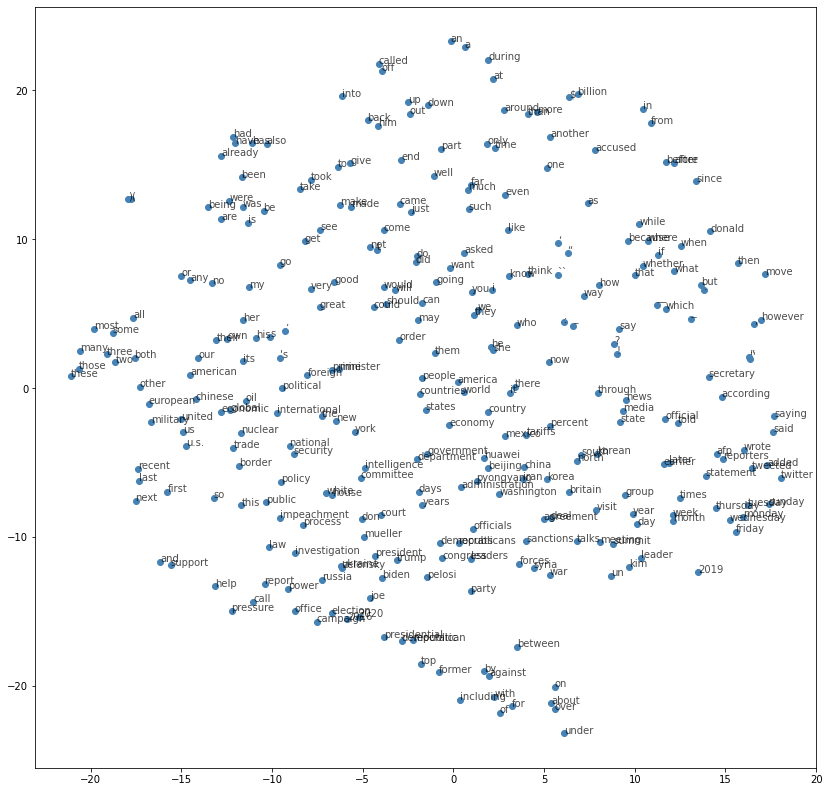

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#emb_i = glove.wi.weight.cpu().data.numpy()
#emb_j = glove.wj.weight.cpu().data.numpy()
emb = embed_matrix_skip
top_k = 300
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[:top_k, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(top_k):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(list(data_skip.word_to_idx.keys())[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

###  A toy task now: find semantically related sentence(s)

CBOW or Skip-gram learn distributed representations for words, what if we want to represent a sentence? Previous methods use tf, idf counts, now we can simply average word embeddings to get a vector to represent a sentence. Now, it's your turn, here is a sentence "Trump went to China last year ', and a list of other sentences, please use the word embeddings that we've learned to find the most similar sentence of s1.

In [ ]:
s1='Trump went to China last year.'

sen_list =['Trump held a talk in the Congress.', 
           'The White House had made a trade deal with Beijing.',
           'Trump visited Beijing a year ago.',
           'The virus has a negative impact for the world economy']

We first define a function to get sentence representation using average word embeddings:

In [ ]:
def get_sentence_vector(sentence, data, model):
    embed_matrix = model.embeddings.weight.detach().cpu().numpy()
    words = word_tokenize(sentence)
    sen_rep = np.zeros(embed_matrix.shape[1])
    for word in words:
        try:
            idx = data.word_to_idx[word]
            sen_rep += embed_matrix[idx]
        except KeyError:
            continue
    return sen_rep    

In [ ]:
s1_rep = get_sentence_vector(s1, data_skip, model_skip)
s1_rep

array([ 0.61942737, -0.62997227, -1.06696548, -0.40687038, -0.13402051,
        0.14373884, -0.69656187, -0.76838519, -0.56965544, -0.06856219,
        0.04529084,  0.82320251, -0.07893301,  0.22900577, -0.70775072,
        0.1477804 ,  1.15636402, -0.46125811, -0.84439615, -1.03024054,
       -1.06242011, -0.76152525,  0.3587474 , -1.70452097,  0.99964156,
       -0.66176289, -0.34746717, -0.61074092,  0.93341418, -0.13521029,
        0.99603611, -0.89125045,  0.74064416, -0.19311856,  0.26615755,
       -0.19996699,  0.48615177,  0.9392484 ,  1.06619966,  0.29315274,
       -1.44483571, -0.56525223,  0.33766615, -0.53379204,  1.98178639,
       -1.39281816,  1.33008876,  0.8182202 ,  0.94255747,  0.04376943])

In [ ]:
# the same distance function we used for word similarity compuation,
# now we know they must have the same dimention
def dist(x,y):   
    return np.sqrt(np.sum((x-y)**2))

In [ ]:
for sen in sen_list:
    temp_sen_rep = get_sentence_vector (sen, data_skip, model_skip)
    dis = dist(s1_rep, temp_sen_rep)
    print(dis)

7.922790023138681
7.586606727651648
6.612904212143436
9.452348378440501


Cool, average word embedding based sentence representation tells us the third sentence is the most similar one to the given sentence.

### Summary
We have shown the procedures to learn word embeddings, but in the real word project you don't have to do such detailed things step by step. What we often do is use Gensim or fastText e.g., [gensim](https://radimrehurek.com/gensim/), [fastText](https://fasttext.cc). 

Word2Vec is the very first trial to learn successful distributed representations for words, however, there are more advanced techniques such as [GloVe](https://nlp.stanford.edu/projects/glove/), [ElMo](https://allennlp.org/elmo), [BERT](https://arxiv.org/pdf/1810.04805.pdf), etc. A latest state-of-art langauge pre-training method: [ELECTRA](https://ai.googleblog.com/2020/03/more-efficient-nlp-model-pre-training.html)

For more advanced text representation techniques, please refer to [HuggingFace](https://huggingface.co) and [AllenNLP](https://allennlp.org).